# PySAD - MedianAbsoluteDeviation

## Carga de datos

Cargamos librerías y datos:

Las típicas (pandas, matplotlib, numpy)...

Funciones de sklearn de preprocesado y métricas.

Modelos y métricas de PyOD.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score

from pysad.models import  MedianAbsoluteDeviation
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator

random_state = np.random.RandomState(42)

In [2]:
df = pd.read_csv('../../Datasets/Dataset_2.csv',index_col='fecha', usecols=['fecha','FormacionNIRHumedadPV', 'FibraticPredNIRHumedadPV','Negro', 'CurvaCola', 'Congelado', 'Hum'])
df['Diferencia'] = df['FormacionNIRHumedadPV'] - df['FibraticPredNIRHumedadPV']
df = df.drop(['FormacionNIRHumedadPV','FibraticPredNIRHumedadPV'], axis=1)
df = df.loc[:,['Diferencia','Negro', 'CurvaCola', 'Congelado', 'Hum']]
df.index = pd.to_datetime(df.index)
df.head(2)

,Diferencia,Negro,CurvaCola,Congelado,Hum
fecha,,,,,
2021-02-10 10:00:00,-6.465569,1,0,1,0
2021-02-10 10:01:00,-6.355772,1,0,1,0


Unimos todas las anomalías en una columna, para posteriormente realizar las métricas tanto para todas las anomalías como para cada una en concreto.

Para ello, sumo las columnas de anomalías, y después las que son mayores que cero las establezco como uno (porque significa que alguna de las columnas si tenía anomalía registrada), las demás como cero.

In [3]:
df['Anomalia'] = df['Negro'] + df['Congelado'] + df['Hum']
df['Anomalia'] = df['Anomalia'].map(lambda x: 1 if x!=0 else 0)

df = df.drop(df[df['Anomalia']==1].index)
df = df.drop(['Negro','Congelado','Hum','Anomalia'], axis=1)

lista_anomalias = ['CurvaCola']

atributos = df.columns.drop(lista_anomalias)
len(atributos)

1

## Escogemos un subconjunto del dataset para entrenamientos más cortos

In [4]:
#df = df.iloc[40000:60000,:]

## Proporción de cada anomalía

In [5]:
def proporciones(df,columna):
    return round(df[df[columna]==1][columna].count()/df[columna].count() *100,3)

lista_proporciones = []

for i in lista_anomalias:
    lista_proporciones.append(proporciones(df,i))


df_proporciones = np.array(lista_proporciones)
df_proporciones = pd.DataFrame(df_proporciones).T
df_proporciones.columns = lista_anomalias

print('Proporción de anomalías en %: ')
df_proporciones.head()

Proporción de anomalías en %: 


,CurvaCola
0,26.495


## Preparación

Separo conjuntos de train, validation y test, y estandarizo:

Separo los atributos en X y las anomalias en Y. De esta manera, al realizar el train_test_split, se mantendrán las proporciones de cada anomalía, con muestreos temporales aleatorios.

Primero separo en train-test (80-20) y después separo el test en test-validation (50-50), para así obtener finalmente train-validation-test (80-10-10).

Una vez separado, entreno el StandardScaler() con el conjunto de entrenamiento, y se lo aplico al conjunto de validación y test.

In [6]:
#Separo los atributos para el entrenamiento de la salida
X = df.loc[:, 'Diferencia']
Y = df.loc[:, lista_anomalias]

#Calculo la proporcion de outliers presentes
proporcion_outliers = round(np.count_nonzero(Y.CurvaCola) / len(Y.CurvaCola),3)

#Separo entrenamiento y test (80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = random_state)

## Entrenamiento

Para ello, establezco primero la lista de hiperparámetros a entrenar y la de métricas a analizar.

creo dos arrays de ceros, uno para las scores y otro para las labels.

Realizo un bucle, estableciendo un entrenamiento por cada hiperparámetro.

Después, extraigo scores y labels, almacenándolas en un array, y calculo las métricas, haciendo lo mismo. Una vez termina el bucle, estos dos vectores los paso a un dataframe para su visualización.

In [7]:
t0 = time()

#Establecemos parametros
metricas_list = ['roc_auc','accuracy','precision','kappa','sensibilidad','especificidad']
anomalia = 'CurvaCola'

#Entrenamiento
clf = MedianAbsoluteDeviation()
calibrator = ConformalProbabilityCalibrator(windowed=False)

clf.fit(np.reshape(X_train.to_list(),(-1,1)))
scores_train = clf.score(np.reshape(X_train.to_list(),(-1,1)))
calibrator.fit(scores_train)

#Prediccion
test_scores = clf.score(np.reshape(X_test.to_list(),(-1,1)))
test_scores = calibrator.transform(test_scores)

t1 = time()
duration = round(t1 - t0, ndigits=4)
print('Tiempo: ', duration)

Tiempo:  78015.3402


## Análisis de Scores:

Dado que PySAD no etiqueta directamente las instancias, realizamos un pequeño análisis de la score de salida de cada una para determinar el umbral adecuado:

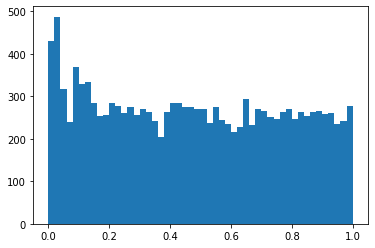

In [8]:
Y_test['scores'] = test_scores
n, bins, patches = plt.hist(Y_test[Y_test['CurvaCola']==1]['scores'], bins=50)
plt.show()

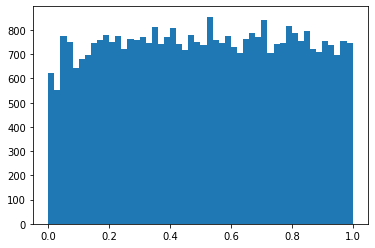

In [9]:
plt.hist(Y_test[Y_test['CurvaCola']==0]['scores'], bins=50)
plt.show()

Miramos los bins:

In [10]:
bins

array([4.46034702e-04, 2.04357416e-02, 4.04254485e-02, 6.04151554e-02,
       8.04048623e-02, 1.00394569e-01, 1.20384276e-01, 1.40373983e-01,
       1.60363690e-01, 1.80353397e-01, 2.00343104e-01, 2.20332811e-01,
       2.40322517e-01, 2.60312224e-01, 2.80301931e-01, 3.00291638e-01,
       3.20281345e-01, 3.40271052e-01, 3.60260759e-01, 3.80250466e-01,
       4.00240173e-01, 4.20229879e-01, 4.40219586e-01, 4.60209293e-01,
       4.80199000e-01, 5.00188707e-01, 5.20178414e-01, 5.40168121e-01,
       5.60157828e-01, 5.80147535e-01, 6.00137241e-01, 6.20126948e-01,
       6.40116655e-01, 6.60106362e-01, 6.80096069e-01, 7.00085776e-01,
       7.20075483e-01, 7.40065190e-01, 7.60054897e-01, 7.80044603e-01,
       8.00034310e-01, 8.20024017e-01, 8.40013724e-01, 8.60003431e-01,
       8.79993138e-01, 8.99982845e-01, 9.19972552e-01, 9.39962259e-01,
       9.59951965e-01, 9.79941672e-01, 9.99931379e-01])

Analizamos la curva roc en función del punto en que discriminemos anomalía de no anomalía:

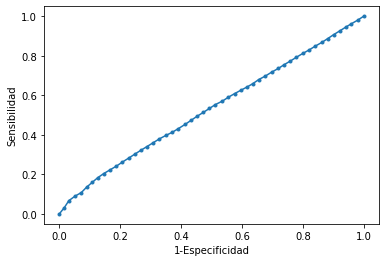

In [11]:
valores = np.array([])
sensibilidades = np.array([])
especificidades = np.array([])
for i in bins:
    Y_test['Y_pred'] = Y_test['scores'].map(lambda x: 1 if x < i else 0)
    valores = np.append(valores,i)
    sensibilidades = np.append(sensibilidades,recall_score(Y_test['CurvaCola'],Y_test['Y_pred']))
    especificidades = np.append(especificidades,recall_score(Y_test['CurvaCola'],Y_test['Y_pred'], pos_label=0))

plt.plot(1 - especificidades, sensibilidades,'.-')
plt.ylabel('Sensibilidad')
plt.xlabel('1-Especificidad')
plt.show()

In [12]:
Y_test['Y_pred'] = Y_test['scores'].map(lambda x: 1 if x < bins[5] else 0)

## Métricas

In [13]:
roc_auc = roc_auc_score(Y_test[anomalia], Y_test['Y_pred'])
accuracy = accuracy_score(Y_test[anomalia],Y_test['Y_pred'])
precision = precision_score(Y_test[anomalia],Y_test['Y_pred'])
kappa = cohen_kappa_score(Y_test[anomalia],Y_test['Y_pred'])
sensibilidad = recall_score(Y_test[anomalia],Y_test['Y_pred'])
especificidad = recall_score(Y_test[anomalia],Y_test['Y_pred'], pos_label=0)

valores = [roc_auc,accuracy,precision,kappa,sensibilidad,especificidad]
metricas = pd.DataFrame(valores)
metricas.index = metricas_list
metricas.columns = [anomalia]

Analizo las métricas:

In [14]:
metricas.T

,roc_auc,accuracy,precision,kappa,sensibilidad,especificidad
CurvaCola,0.522436,0.702755,0.353586,0.05584,0.134844,0.910028


In [15]:
Y_test.to_csv('Resultados/PySAD_MAD_completo.csv')